In [8]:
from structured.DataRetriever import DataRetriever
import numpy as np
import pandas as pd

dt = DataRetriever("D:/Descargas/i2ascii-files/i2ascii-files/", 200)
dt.set_target(['m_elev','m_az'])
dt.get_det_type(False)
dt.set_selected_hits(10)
target, data, compare_data = dt.load_data(
    get_sel_events = False,
    filter_bbfit_null = False,
    get_bbfit_data = True,
    get_aafit_data = True
)

In [2]:
# En lugar de importar la función del script utilizado en clase, se reimplementa con ligeras variaciones para
# adaptarse a las necesidades del ejercicio
def grafica_real_vs_pred_mod(y_true, y_pred, evaluated_metrics, algorithm_name):
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    ax.set_xlabel('Real class value')
    ax.set_ylabel('Prediction')
    title = algorithm_name + '\n'
    for name, result in evaluated_metrics.items():
        title += name + ': ' + str(round(result, 3)) + ' '
        
    plt.title(title)
    plt.show()

In [9]:
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.svm import LinearSVR, SVR, NuSVR
#import crfsuite as sk_crf
from sklearn.multioutput import MultiOutputRegressor
#import xgboost as xgb

rand_state = 50
jobs = 6

# Métricas de evaluación que se utilizarán. No nos preocupamos en negarlas debido a que no se utilizarán de forma automática,
# solo las visualizaremos
metrics_dict = {
  'MAE': metrics.mean_absolute_error,
  'RMSE': lambda y, y_pred:
          sqrt(metrics.mean_squared_error(y, y_pred)),
  'E_VARIANCE': metrics.explained_variance_score
}

algorithms_dict = {}

# Algoritmo 1: No Outliers + Standarización + RandomForest
#steps = [
#    ('standardization', StandardScaler()),
#    ('rforest', RandomForestRegressor(n_estimators=50, random_state=rand_state, n_jobs=jobs))]
#algorithms_dict['STD_RF'] = Pipeline(steps)

# Algoritmo 2: No Outliers + Standarización + Multi-RandomForest
steps = [
    ('standardization', StandardScaler()),
    ('multi_rforest', MultiOutputRegressor(RandomForestRegressor(n_estimators=50, random_state=rand_state, n_jobs=jobs), n_jobs=jobs))]
algorithms_dict['STD_MULT_RF'] = Pipeline(steps)

# Algoritmo 3: No Outliers + Standarización + MLPRegressor
#steps = [
#    ('standardization', StandardScaler()),
#    ('mlp', MLPRegressor(random_state=rand_state))]
#algorithms_dict['STD_MLP'] = Pipeline(steps)

# Algoritmo 4: No Outliers + Standarización + Multi-GradientBoostingRegressor
#steps = [
#    ('standardization', StandardScaler()),
#    ('multi_gbr', MultiOutputRegressor(GradientBoostingRegressor(random_state=rand_state), n_jobs=jobs))]
#algorithms_dict['STD_MULT_GBR'] = Pipeline(steps)


algorithms_dict2 = {}

# Algoritmo 5: No Outliers + Standarización + LinearSVR
#steps = [
#    ('standardization', StandardScaler()),
#    ('linsvr', LinearSVR(random_state=rand_state))]
#algorithms_dict2['STD_LSVR'] = Pipeline(steps)

# Algoritmo 6: No Outliers + Standarización + Multi-LinearSVR
#steps = [
#    ('standardization', StandardScaler()),
#    ('multi_linsvr', MultiOutputRegressor(LinearSVR(random_state=rand_state), n_jobs=jobs))]
#algorithms_dict2['STD_MULT_LSVR'] = Pipeline(steps)

# Algoritmo 7: No Outliers + Standarización + SVR
#steps = [
#    ('standardization', StandardScaler()),
#    ('svr', SVR())]
#algorithms_dict2['STD_SVR'] = Pipeline(steps)

# Algoritmo 8: No Outliers + Standarización + Multi-SVR
steps = [
    ('standardization', StandardScaler()),
    ('multi_linsvr', MultiOutputRegressor(SVR(), n_jobs=jobs))]
algorithms_dict2['STD_MULT_SVR'] = Pipeline(steps)

# Algoritmo 9: No Outliers + Standarización + NuSVR
#steps = [
#    ('standardization', StandardScaler()),
#    ('svr', NuSVR())]
#algorithms_dict2['STD_SVR'] = Pipeline(steps)

# Algoritmo 10: No Outliers + Standarización + Multi-NuSVR
steps = [
    ('standardization', StandardScaler()),
    ('multi_linsvr', MultiOutputRegressor(NuSVR(), n_jobs=jobs))]
algorithms_dict2['STD_MULT_NuSVR'] = Pipeline(steps)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=rand_state)

In [5]:
print('BBFIT MAE: ' + str(metrics_dict['MAE'](compare_data, target)))
print('BBFIT RMSE: ' + str(metrics_dict['RMSE'](compare_data, target)))
print('BBFIT E_VARIANCE: ' + str(metrics_dict['E_VARIANCE'](compare_data, target)))

BBFIT MAE: 0.2955369833174801
BBFIT RMSE: 0.8496117170174486
BBFIT E_VARIANCE: 0.6427135461013335


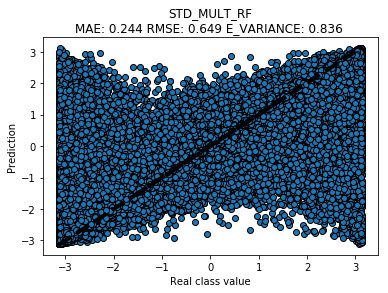

In [6]:
# Se realizan las 6 predicciones y se almacenan en un diccionario con nombres descriptivos 
y_pred_dict = {}
for alg_name, alg in algorithms_dict.items():
    y_pred_dict[alg_name] = cross_val_predict(alg, data, target, n_jobs=jobs,
                                                              cv=KFold(n_splits=5, random_state=rand_state))

evaluated = {}
for name, prediction in y_pred_dict.items():
    for metric_name, metric in metrics_dict.items():
        evaluated[metric_name] = metric(target, prediction)

    grafica_real_vs_pred_mod(target, prediction, evaluated, name)

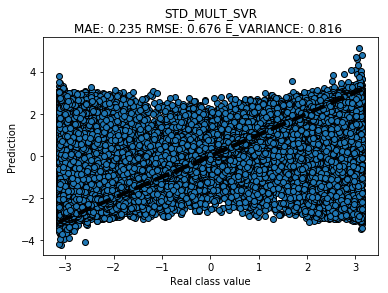

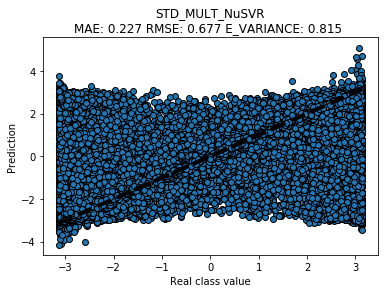

In [7]:
# Se realizan las 6 predicciones y se almacenan en un diccionario con nombres descriptivos 
y_pred_dict2 = {}
for alg_name, alg in algorithms_dict2.items():
    y_pred_dict2[alg_name] = cross_val_predict(alg, data, target, n_jobs=jobs,
                                                              cv=KFold(n_splits=5, random_state=rand_state))

evaluated2 = {}
for name, prediction in y_pred_dict2.items():
    for metric_name, metric in metrics_dict.items():
        evaluated2[metric_name] = metric(target, prediction)

    grafica_real_vs_pred_mod(target, prediction, evaluated2, name)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [50, 100, 150],
              'max_depth': [4, 6, 8, None],
              'min_samples_split': [2, 3, 4],
              'min_samples_leaf': [5],
              'max_features': [0.35, 0.4, 0.45],
              'criterion': ['mse', 'mae']
             # 'warm_leaf_nodes': [True, False]
             }

modelo_optimizador = MultiOutputRegressor(RandomForestRegressor(random_state=rand_state, n_jobs=jobs), n_jobs=jobs)
modelo_optimizador = RandomForestRegressor(random_state=rand_state, n_jobs=jobs)

gs_cv = GridSearchCV(modelo_optimizador, param_grid, n_jobs=jobs, cv=5).fit(X_train,y_train)

print(gs_cv.best_params_)
n_estimators = gs_cv.best_params_['n_estimators']
#max_depth = gs_cv.best_params_['max_depth']
min_samples_split = gs_cv.best_params_['min_samples_split']
min_samples_leaf = gs_cv.best_params_['min_samples_leaf']
max_features = gs_cv.best_params_['max_features']
#warm_leaf_nodes = gs_cv.best_params_['warm_leaf_nodes']